In [1]:
# Compute overlap proportion between: 
# 1) clustering of individuals based on similar FCI responses
# 2) FCI question clusters results and their behavioral interpretations
# Author: Jessica Bartley
# Last edited: 11/6/17

%matplotlib inline

# libraries
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
#import seaborn as sns

In [2]:
# read in files
f_idKey = "idKey.csv" #Key from study PIDs to IDs Eric used in R code (lets call those rIDs)
f_fciQcomm = "fci_charac.csv" #List of question (lets shorten to Q) community membership for all FCI answer choices.
f_fciPcomm = "communities.csv" #List of rIDs making up each person (lets shorten to P) cluster
f_fciresp = "responses.csv" #Each subject's response for the 9 in-scanner FCI questions.

In [3]:
"""
Global definitions
"""

# Number of P clusters observed
nclusters = 13

# all possible in-scanner FCI Q responses (named via Eric's Q coding scheme)
Qs = ['X2a', 'X2b', 'X2c', 'X2d', 'X3a', 'X3b', 'X3c', \
      'X3e', 'X6a', 'X6b', 'X6c', 'X6e', 'X7a', 'X7b', \
      'X7c', 'X7e', 'X8a', 'X8b', 'X8d', 'X8e', 'X12b', \
      'X12c', 'X12d', 'X12e', 'X14a', 'X14b', 'X14c', \
      'X14d', 'X27a', 'X27b', 'X27c', 'X27d', 'X29a', \
      'X29b', 'X29d', 'X29e']

# Incorrect FCI answer choices not included in Eric's origional Q community analysis (due to infrequent responses). 
missingQs = ['X6e', 'X12e', 'X29a', 'X29e']

# Eric's names for each FCI Q community membership. Cluster '10' has the correct answer choices and cluster 'NA' has the above missingQs
allmems = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'NA']

# Number of subjects observed for each P cluster, ordered sequentially from cluster 1 to cluster 13
clustersizes = [24, 17, 10, 10, 8, 7, 7, 5, 5, 5, 4, 4, 2]

# All P clusters by name
clusterlist = ('cluster1','cluster2','cluster3','cluster4','cluster5',\
              'cluster6','cluster7','cluster8','cluster9','cluster10',\
              'cluster11','cluster12','cluster13')

In [4]:
def dequote(a_string):
    """
    If a string has single or double quotes around it, remove them.
    Make sure the pair of quotes match.
    If a matching pair of quotes is not found, return the string unchanged.
    """
    if (a_string[0] == a_string[-1]) and a_string.startswith(("'", '"')):
        return a_string[1:-1]
    return a_string

In [5]:
def listToFloat(a_list):
    """
    If all elements in a list are numbers being interpreted as strings then turn them into floats.
    """
    a = []
    for i in range(0,len(a_list)):
        a.append(int(dequote(a_list[i])))
    a_list = a
    return a_list

In [6]:
def dropExtraQs(allQs, scannerQs):
    """
    Remove all quesiton answer choices that were not shown in the scanner.
    """
    qlist = []
    for item in allQs:
        if item[0] in scannerQs:
            qlist.append(item)
    return qlist

In [7]:
def computeProportion(a_list):
    """
    Creates dictionay where 
    keys = Q community membership 
    value = proportion of Q responses falling within any given Q community.
    e.g. for Q2 in cluster 1: {'1':0.75, '2': 0.2, '3': 0 ...}
    """
    proportion = {}
    for item in a_list:
        key = str(item)
        if key in proportion.keys():
            proportion[key] += 1
        else:
            proportion[key] = 1
    total = sum(proportion.itervalues(), 0.0)
    proportion = {item: value / total for item, value in proportion.iteritems()}    
    for mem in allmems:
        if mem not in proportion.keys():
            proportion.update({mem: 0})
    return proportion

In [8]:
# convert files to readable format
list_idKey = np.genfromtxt(f_idKey, names=True, delimiter=',', dtype=None)
list_pComm = np.genfromtxt(f_fciPcomm, names=True, delimiter=',', dtype=None)
list_Qcomm = np.genfromtxt(f_fciQcomm, names=True, delimiter=',', dtype=None)
list_Qcomm = dropExtraQs(list_Qcomm, Qs) # keep only Q responses shown within the scanning session
list_fciresp = np.genfromtxt(f_fciresp, names=True, delimiter=',', dtype=None)


# make the above lists into separate strings
communities = zip(*list_pComm)[0] # P clusters string {"1.1", "1.2"...}
subjects = zip(*list_pComm)[1] # rIDs ordered by appearence in P clusters
rIDs = zip(*list_idKey)[0]
rIDs = listToFloat(rIDs) # rIDs ordered  numerically
IDs = zip(*list_idKey)[1] # Study IDs
QIDs = zip(*list_Qcomm)[0] # Eric's Q response IDs
questionlist = list(list_fciresp.dtype.names) # Qs asked within scanner
questionlist.pop(0) # remove empty first element from list


# generate dictionaries
commKey = {} # rID : P cluster
for counter, communitymem in enumerate(communities):
    commKey.update({subjects[counter]: communitymem})

idKey_pid2rid = {} # study ID : rID
for counter, rID in enumerate(rIDs):
    idKey_pid2rid.update({IDs[counter]: rID})

idKey_rid2pid = {} # rID : study ID
for counter, rID in enumerate(rIDs):
    idKey_rid2pid.update({rID: IDs[counter]})
    
questKey = {} # FCI Q response code : Q community membership
for counter, qid in enumerate(QIDs):
    questKey.update({qid: list_Qcomm[counter][1]})
for question in questionlist:
    x = "{0}".format(question.replace('Q','X'))
    questKey.update({x+'N':0})
for missingQ in missingQs:
    questKey.update({missingQ:'NA'})
    
pComm = {} # P cluster number : rIDs
for pair in list_pComm:
    key = str(pair[0].split('.')[0].replace('\"',''))
    value = pair[1]
    if key in pComm.keys():
        pComm[key].append(value)
    else:
        pComm[key] = []
        pComm[key].append(value)

In [9]:
def respToQcode():
    """
    Converts in-scanner responses (1="a", 2="b"...) to FCI response codes ("X2a", "X2b"...)
    e.g. takes in ('"216"', 3, 4, 3, 4, 2, 1, 2, 3, 2)
    and gives back ('"216"', 'X2c', 'X3e', 'X6b', 'X7e', 'X8b', 'X12b', 'X14b', 'X27c', 'X29b')
    """
    # row is an integer in [0,len(list_fciresp)]
    # col is an integer in [0,len(list_fciresp.dtype.names)-1]
    names = list_fciresp.dtype.names
    list_fciresp_mod = []
    for participant in list_fciresp:
        sublist = []
        for name in names:
            if 'q' not in name.lower():
                sublist.append(participant[name])
            else:
                qnumber = int(name[1:])
                # Some origional FCI answer choices were not shown in the scanner
                # (the in-scanner FCI only showed 4 answer choices while the origional FCI has 5)
                # e.g. if an origional FCI answer coded as "d" was not shown, then the corresponding
                # in-scanner coded as "d" would actually map to origional FCI answer choice "e".
                # Below is a re-odering of those in-scanner answer choices to map them to the
                # correct origional FCI answer choice.
                def NumberAnswerToLetterAnswer(x):
                    if qnumber in [3,6,7]:
                        if x == 1:
                            return 'a'
                        elif x == 2:
                            return 'b'
                        elif x == 3:
                            return 'c'
                        elif x == 4:
                            return 'e'
                        else:
                            return 'N'
                    elif qnumber in [8,29]:
                        if x == 1:
                            return 'a'
                        elif x == 2:
                            return 'b'
                        elif x == 3:
                            return 'd'
                        elif x == 4:
                            return 'e'
                        else:
                            return 'N'
                    elif qnumber in [12]:
                        if x == 1:
                            return 'b'
                        elif x == 2:
                            return 'c'
                        elif x == 3:
                            return 'd'
                        elif x == 4:
                            return 'e'
                        else:
                            return 'N'
                    else:
                        if x == 1:
                            return 'a'
                        elif x == 2:
                            return 'b'
                        elif x == 3:
                            return 'c'
                        elif x == 4:
                            return 'd'
                        else:
                            return 'N'
                x = "{0}{1}".format(name.replace('Q','X'),NumberAnswerToLetterAnswer(participant[name]))
                sublist.append(x)
        list_fciresp_mod.append(tuple(sublist))    
    return list_fciresp_mod

In [10]:
# The below gives each subject's index in the respToQcode() list of answer choices per subject ID
idToClusterIndex = {} # Study ID : corresponding P cluster index
person_list = []
for i in range(0,len(respToQcode())):
    person_list.append(dequote(respToQcode()[i][0]))
for counter, person in enumerate(person_list):
    personindex = [i for i, row in enumerate(respToQcode()) if respToQcode()[counter][0] in row] #index of subject in respToQcode
    idToClusterIndex.update({respToQcode()[counter][0]: personindex})

In [173]:
"""
Compute the proportion of Q community membership represented within each P cluster
"""

# Step 1: compute proportion of Q community membership for each Q within a P cluster 

personlist = []
for i in range(0,len(respToQcode())):
    person_list.append(dequote(respToQcode()[i][0]))

# Create nested dictionary with: 
# dict structure: allMemberships['P cluster']['Question']['Q membership'] = Proportion
# e.g. allMemberships['11']['Q2']['1'] = 0.0046
# key = P cluster name
# value = dictionary w/ 
#    key = Q# 
#    value = dictionary w/ 
#        key = Q community membership name 
#        value = proportion of Q community membership
allMemberships = {}
accuracy = {} # P cluster : average accuracy assoicated with P cluster
for cluster in pComm.keys(): #loop through P clusters
    clustMembership = {}
    for qcounter, question in enumerate(questionlist): #loop through questions in P cluster
        FCImembership_list = []
        for idcounter, id in enumerate(pComm[cluster]): #loop through subject responses to question
            person = '"' + str(idKey_rid2pid[id]) + '"'
            num = str(idKey_rid2pid[id])
            numAsString = '"' + num + '"'
            index = idToClusterIndex[numAsString][0]
            #map Q response code to Q community membership
            FCImembership_list.append(questKey[respToQcode()[index][qcounter+1]])
        Qmembership = computeProportion(FCImembership_list)
        clustMembership.update({question: Qmembership})
    #get average accuracy in P cluster to use later
    acc_list = []
    for question in questionlist:
        acc_list.append(clustMembership[question]['10'])
    avg_acc = reduce(lambda x, y: x + y, acc_list) / len(acc_list)
    accuracy.update({cluster: avg_acc})
    allMemberships.update({cluster: clustMembership})
print accuracy

# Step 2: compute proportion of Q community membership per cluster (average across Q's within a P cluster)

# Create nested dictionary with:
# dict structure: clusterdict['P cluster']['Q membership'] = Average proportion
# e.g. clusterdict['2']['10'] = 0.732
# key = P cluster name
# value = dictionary w/ 
#    key = Q community membership name 
#    value = Average proportion across cluster
clusterdict = {}
for cluster in pComm.keys(): #loop through P clusters
    d = {}
    for mem in allmems: #loop through Q community memberships
        #get Q community membership proportion across questions
        proportion_list = []
        for question in questionlist: #loop through questions in P cluster
            proportion_list.append(allMemberships[cluster][question][mem]) #gives [propQ1,propQ2,...] for each mem in allmems
        #compute average proportion of Q community membership for P cluster
        d.update({mem: reduce(lambda x, y: x + y, proportion_list) / len(proportion_list)})
    clusterdict.update({cluster: d})

    
# Step 3: scale Q community membership proportions by P cluster size for visualization

scaledProportions = {}
for cluster in pComm.keys(): #loop through P clusters
    scaledNestedDict = {}
    keys = clusterdict[cluster].keys() #Q community memberships
    values = clusterdict[cluster].values() #average (unscaled) proportions
    scaledValues = []
    #scale average Q community membership proportions by cluster size
    for value in values:
        scaledValues.append(value*(len(pComm[cluster])/sum(clustersizes)))
    for index, key in enumerate(keys):
        scaledNestedDict.update({key: scaledValues[index]})
    scaledProportions.update({cluster: scaledNestedDict})

{'11': 0.4722222222222222, '10': 0.4222222222222223, '13': 0.1111111111111111, '12': 0.4166666666666667, '1': 0.7777777777777777, '3': 0.5333333333333333, '2': 0.7320261437908495, '5': 0.7777777777777778, '4': 0.6555555555555556, '7': 0.4285714285714286, '6': 0.5714285714285714, '9': 0.2888888888888889, '8': 0.5111111111111111}


In [12]:
# generate individual arrays for each cluster membership profile
# There must be a more pythonic way to do this
# This is only used if I'm visualizing the unscaled proportions
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []
cluster10 = []
cluster11 = []
cluster12 = []
cluster13 = []
for mem in allmems:
    cluster1.append(clusterdict['1'][mem])
    cluster2.append(clusterdict['2'][mem])
    cluster3.append(clusterdict['3'][mem])
    cluster4.append(clusterdict['4'][mem])
    cluster5.append(clusterdict['5'][mem])
    cluster6.append(clusterdict['6'][mem])
    cluster7.append(clusterdict['7'][mem])
    cluster8.append(clusterdict['8'][mem])
    cluster9.append(clusterdict['9'][mem])
    cluster10.append(clusterdict['10'][mem])
    cluster11.append(clusterdict['11'][mem])
    cluster12.append(clusterdict['12'][mem])
    cluster13.append(clusterdict['13'][mem])

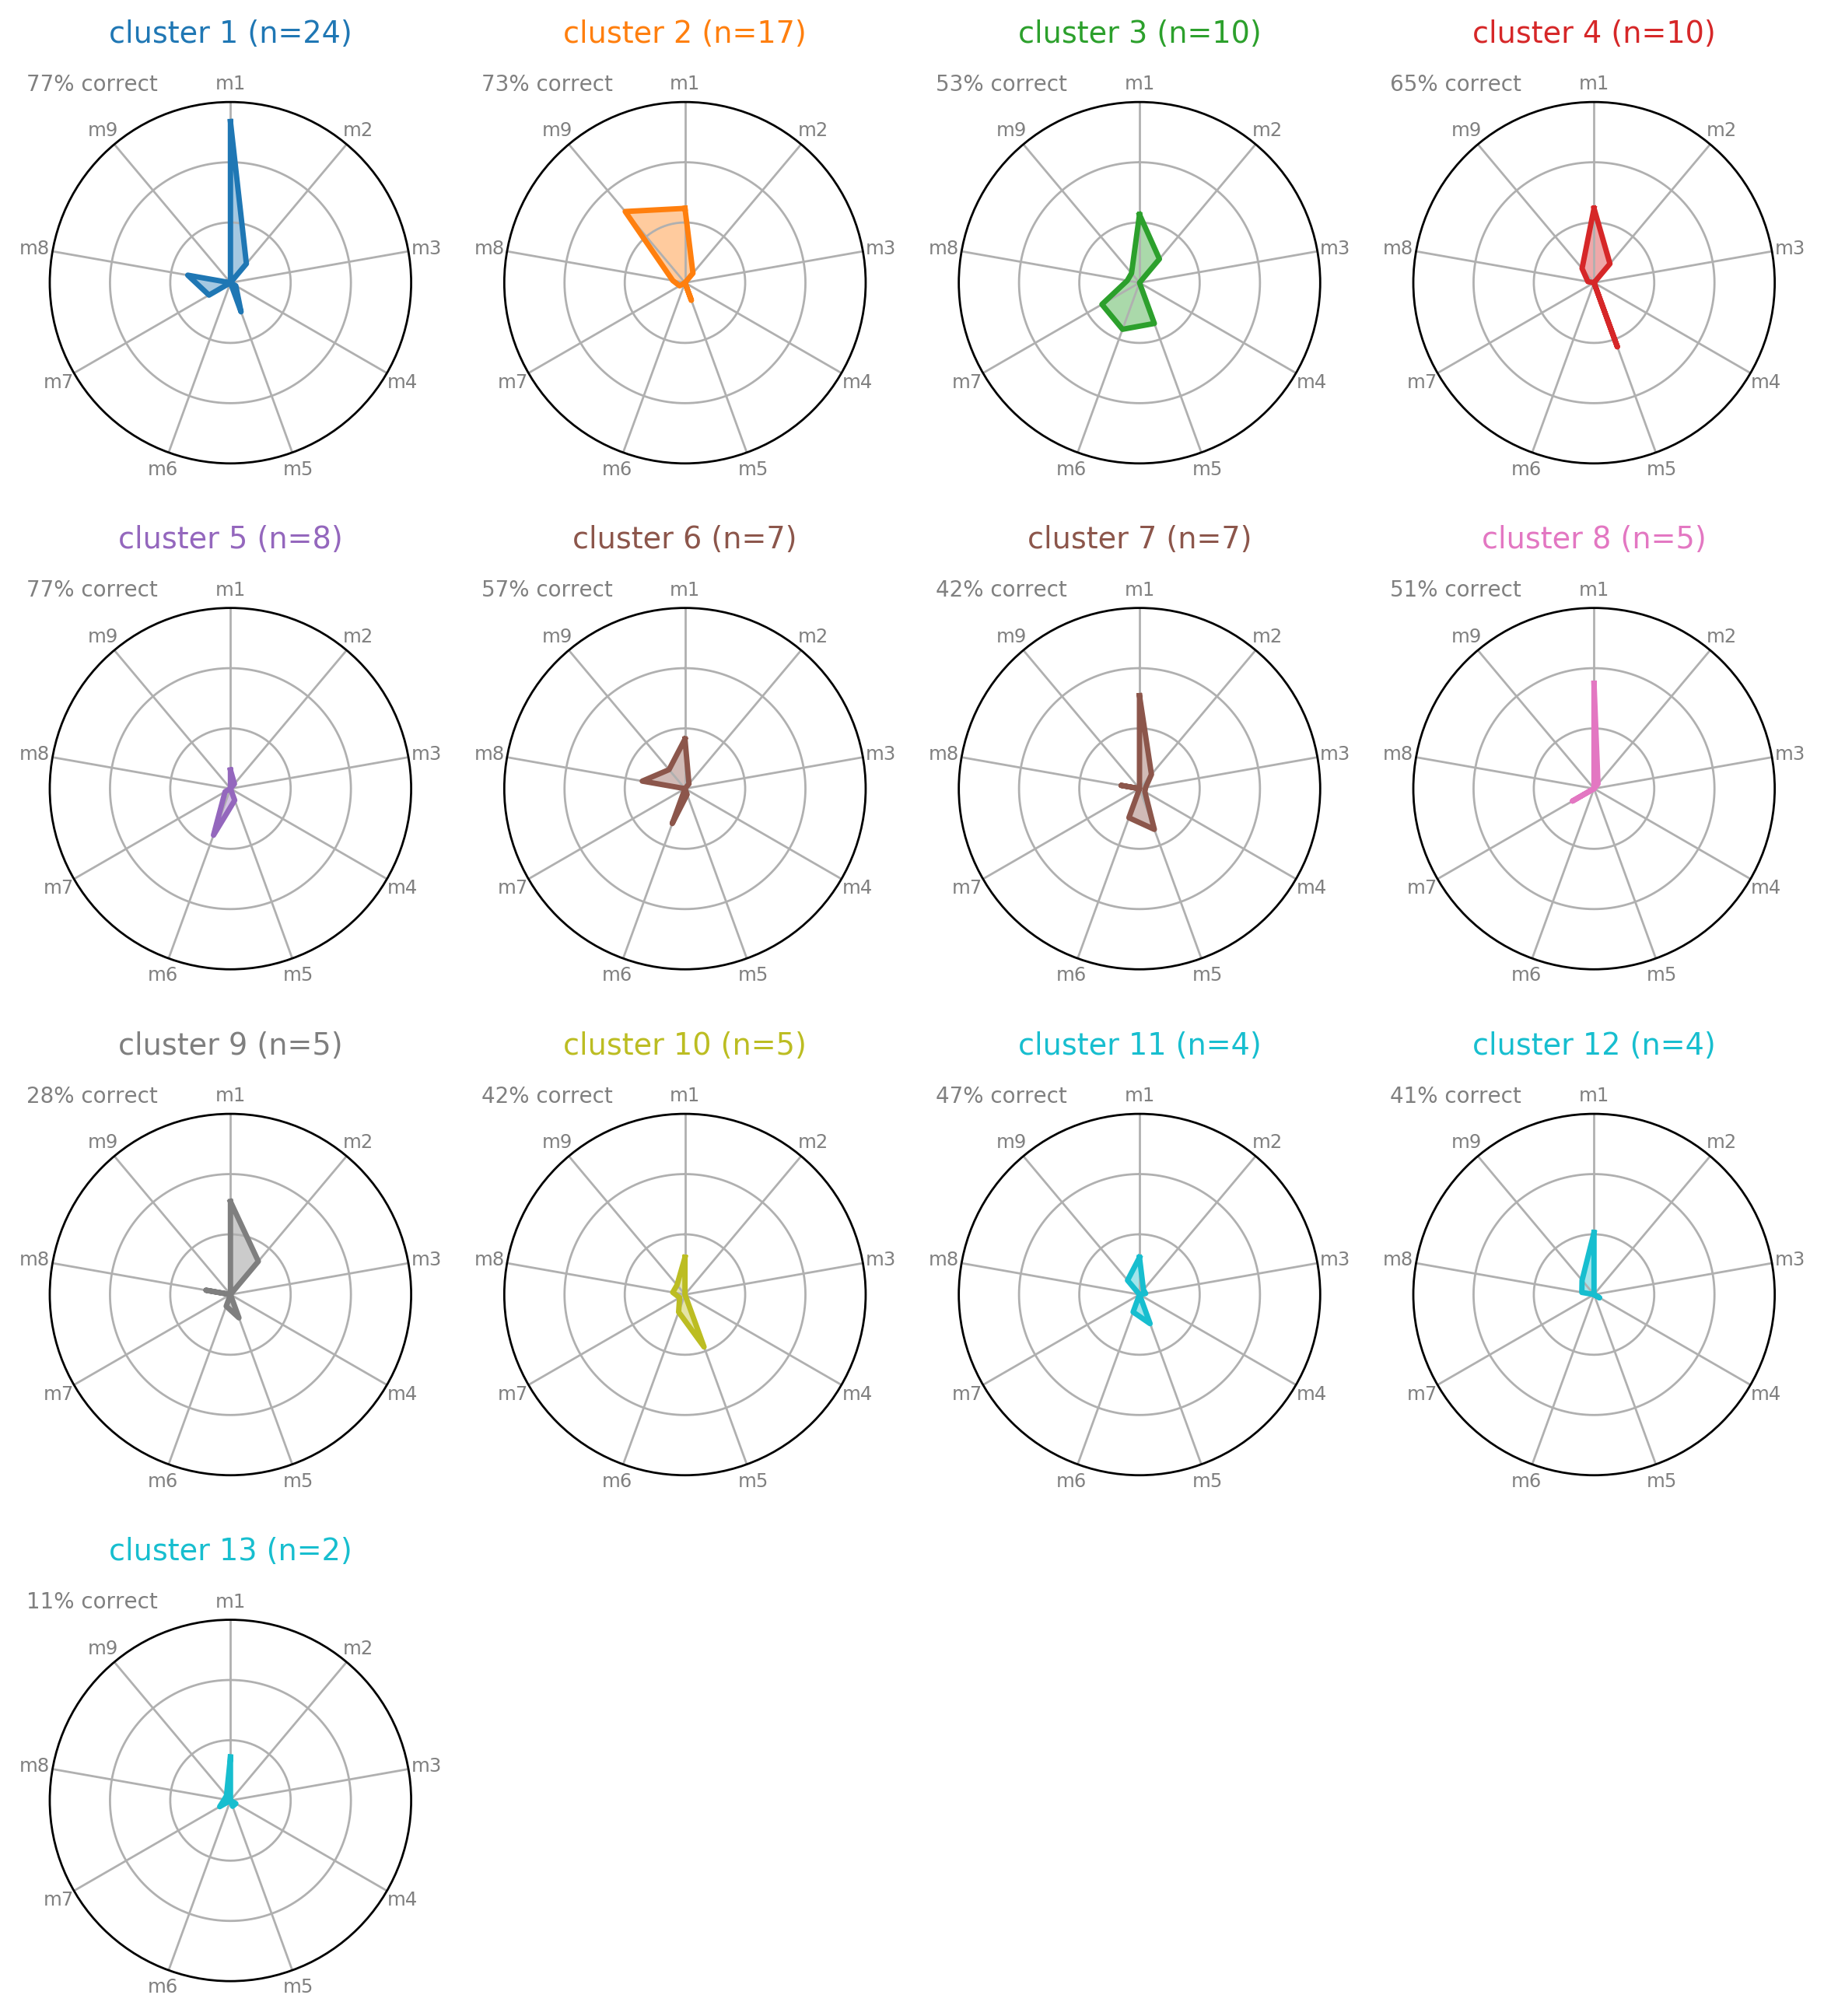

In [182]:
"""
Create Facited radar plots
"""

# Set data
df = pd.DataFrame({
'group': ['1','2','3','4','5','6','7','8','9','10','11','12','13'],
# The below are not scaled for cluster size
#'m1': [cluster1[0],cluster2[0],cluster3[0],cluster4[0],cluster5[0],cluster6[0],cluster7[0],cluster8[0],cluster9[0],cluster10[0],cluster11[0],cluster12[0],cluster13[0]],
#'m2': [cluster1[1],cluster2[1],cluster3[1],cluster4[1],cluster5[1],cluster6[1],cluster7[1],cluster8[1],cluster9[1],cluster10[1],cluster11[1],cluster12[1],cluster13[1]],
#'m3': [cluster1[2],cluster2[2],cluster3[2],cluster4[2],cluster5[2],cluster6[2],cluster7[2],cluster8[2],cluster9[2],cluster10[2],cluster11[2],cluster12[2],cluster13[2]],
#'m4': [cluster1[3],cluster2[3],cluster3[3],cluster4[3],cluster5[3],cluster6[3],cluster7[3],cluster8[3],cluster9[3],cluster10[3],cluster11[3],cluster12[3],cluster13[3]],
#'m5': [cluster1[4],cluster2[4],cluster3[4],cluster4[4],cluster5[4],cluster6[4],cluster7[4],cluster8[4],cluster9[4],cluster10[4],cluster11[4],cluster12[4],cluster13[4]],
#'m6': [cluster1[5],cluster2[5],cluster3[5],cluster4[5],cluster5[5],cluster6[5],cluster7[5],cluster8[5],cluster9[5],cluster10[5],cluster11[5],cluster12[5],cluster13[5]],
#'m7': [cluster1[6],cluster2[6],cluster3[6],cluster4[6],cluster5[6],cluster6[6],cluster7[6],cluster8[6],cluster9[6],cluster10[6],cluster11[6],cluster12[6],cluster13[6]],
#'m8': [cluster1[7],cluster2[7],cluster3[7],cluster4[7],cluster5[7],cluster6[7],cluster7[7],cluster8[7],cluster9[7],cluster10[7],cluster11[7],cluster12[7],cluster13[7]],
#'m9': [cluster1[8],cluster2[8],cluster3[8],cluster4[8],cluster5[8],cluster6[8],cluster7[8],cluster8[8],cluster9[8],cluster10[8],cluster11[8],cluster12[8],cluster13[8]],
#'m10': [cluster1[9],cluster2[9],cluster3[9],cluster4[9],cluster5[9],cluster6[9],cluster7[9],cluster8[9],cluster9[9],cluster10[9],cluster11[9],cluster12[9],cluster13[9]],
#'mN': [cluster1[10],cluster2[10],cluster3[10],cluster4[10],cluster5[10],cluster6[10],cluster7[10],cluster8[10],cluster9[10],cluster10[10],cluster11[10],cluster12[10],cluster13[10]]

# The below are scaled by cluster size. Probably the best way to do it.
'm1': [scaledProportions['1']['1'],scaledProportions['2']['1'],scaledProportions['3']['1'],scaledProportions['4']['1'],scaledProportions['5']['1'],scaledProportions['6']['1'],scaledProportions['7']['1'],scaledProportions['8']['1'],scaledProportions['9']['1'],scaledProportions['10']['1'],scaledProportions['11']['1'],scaledProportions['12']['1'],scaledProportions['13']['1']],
'm2': [scaledProportions['1']['2'],scaledProportions['2']['2'],scaledProportions['3']['2'],scaledProportions['4']['2'],scaledProportions['5']['2'],scaledProportions['6']['2'],scaledProportions['7']['2'],scaledProportions['8']['2'],scaledProportions['9']['2'],scaledProportions['10']['2'],scaledProportions['11']['2'],scaledProportions['12']['2'],scaledProportions['13']['2']],
'm3': [scaledProportions['1']['3'],scaledProportions['2']['3'],scaledProportions['3']['3'],scaledProportions['4']['3'],scaledProportions['5']['3'],scaledProportions['6']['3'],scaledProportions['7']['3'],scaledProportions['8']['3'],scaledProportions['9']['3'],scaledProportions['10']['3'],scaledProportions['11']['3'],scaledProportions['12']['3'],scaledProportions['13']['3']],
'm4': [scaledProportions['1']['4'],scaledProportions['2']['4'],scaledProportions['3']['4'],scaledProportions['4']['4'],scaledProportions['5']['4'],scaledProportions['6']['4'],scaledProportions['7']['4'],scaledProportions['8']['4'],scaledProportions['9']['4'],scaledProportions['10']['4'],scaledProportions['11']['4'],scaledProportions['12']['4'],scaledProportions['13']['4']],
'm5': [scaledProportions['1']['5'],scaledProportions['2']['5'],scaledProportions['3']['5'],scaledProportions['4']['5'],scaledProportions['5']['5'],scaledProportions['6']['5'],scaledProportions['7']['5'],scaledProportions['8']['5'],scaledProportions['9']['5'],scaledProportions['10']['5'],scaledProportions['11']['5'],scaledProportions['12']['5'],scaledProportions['13']['5']],
'm6': [scaledProportions['1']['6'],scaledProportions['2']['6'],scaledProportions['3']['6'],scaledProportions['4']['6'],scaledProportions['5']['6'],scaledProportions['6']['6'],scaledProportions['7']['6'],scaledProportions['8']['6'],scaledProportions['9']['6'],scaledProportions['10']['6'],scaledProportions['11']['6'],scaledProportions['12']['6'],scaledProportions['13']['6']],
'm7': [scaledProportions['1']['7'],scaledProportions['2']['7'],scaledProportions['3']['7'],scaledProportions['4']['7'],scaledProportions['5']['7'],scaledProportions['6']['7'],scaledProportions['7']['7'],scaledProportions['8']['7'],scaledProportions['9']['7'],scaledProportions['10']['7'],scaledProportions['11']['7'],scaledProportions['12']['7'],scaledProportions['13']['7']],
'm8': [scaledProportions['1']['8'],scaledProportions['2']['8'],scaledProportions['3']['8'],scaledProportions['4']['8'],scaledProportions['5']['8'],scaledProportions['6']['8'],scaledProportions['7']['8'],scaledProportions['8']['8'],scaledProportions['9']['8'],scaledProportions['10']['8'],scaledProportions['11']['8'],scaledProportions['12']['8'],scaledProportions['13']['8']],
'm9': [scaledProportions['1']['9'],scaledProportions['2']['9'],scaledProportions['3']['9'],scaledProportions['4']['9'],scaledProportions['5']['9'],scaledProportions['6']['9'],scaledProportions['7']['9'],scaledProportions['8']['9'],scaledProportions['9']['9'],scaledProportions['10']['9'],scaledProportions['11']['9'],scaledProportions['12']['9'],scaledProportions['13']['9']],
#'m10': [scaledProportions['1']['10'],scaledProportions['2']['10'],scaledProportions['3']['10'],scaledProportions['4']['10'],scaledProportions['5']['10'],scaledProportions['6']['10'],scaledProportions['7']['10'],scaledProportions['8']['10'],scaledProportions['9']['10'],scaledProportions['10']['10'],scaledProportions['11']['10'],scaledProportions['12']['10'],scaledProportions['13']['10']],
#'mN': [scaledProportions['1']['NA'],scaledProportions['2']['NA'],scaledProportions['3']['NA'],scaledProportions['4']['NA'],scaledProportions['5']['NA'],scaledProportions['6']['NA'],scaledProportions['7']['NA'],scaledProportions['8']['NA'],scaledProportions['9']['NA'],scaledProportions['10']['NA'],scaledProportions['11']['NA'],scaledProportions['12']['NA'],scaledProportions['13']['NA']]
})


def make_spider( row, title, color):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(4,4,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories, color='grey', size=7)
    
    # Extend margins
    plt.subplots_adjust(left=0.2, hspace=0.4)
    #plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    # Draw ylabels
    ax.set_rlabel_position(0)
    #values if I'm plotting unscaled values and including cluster 10 (correct answers):
#    plt.yticks([.2,.4,.6], ["","",""], color="grey", size=6)
#    plt.ylim(0,.85)
    #values if I'm plotting unscaled values and not including cluster 10 (correct answers):
#    plt.yticks([.2,.4,.6], ["","",""], color="grey", size=6)
#    plt.ylim(0,.15)
    #values if I'm plotting the scaled values and including cluster 10 (correct answers):
#    plt.yticks([.5,.1,.15], [".5",".1",".15"], color="grey", size=6)
#    plt.ylim(0,0.2)
    #values if I'm plotting the scaled values and not including cluster 10 (correct answers)
    plt.yticks([.01,.02], ["",""], color="grey", size=6)
    plt.ylim(0,0.03)

    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    ttl = plt.title(title, size=11, color=color, y=1.052)
    ttl.set_position([.5, 1.12])

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=250
plt.figure(figsize=(3200/my_dpi, 3200/my_dpi), dpi=my_dpi)

# Create a color palette:
# good options: "tab10", "Set2", "gist_stern", "tab20", "tab20b", "Paired", "Dark2", "Set1"
my_palette = plt.cm.get_cmap("tab10", len(df.index)) 

# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='cluster '+df['group'][row]+' (n='+str(clustersizes[row])+')', color=my_palette(row+1))
#    plt.text(1, 0.037, r'accuracy {0}%'.format(acc), color="gray", size=8.5)
    plt.text(-.815, 0.04651, r'{0}% correct'.format(int(accuracy[df['group'][row]]*100)), color="gray", size=8)

plt.show()
plt.clf()

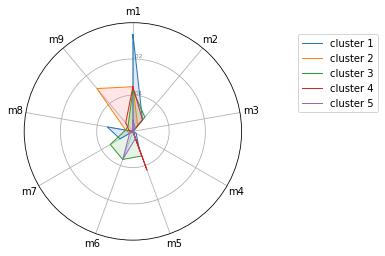

In [15]:
"""
Create singular radar plot
Results are basically unreadable...
"""

# Set data
df = pd.DataFrame({
'group': ['1 (n=27)','2 (n=18)','3 (n=10)','4 (n=10)','5 (n=8)',\
          '6 (n=7)','7 (n=7)','8 (n=5)','9 (n=5)','10 (n=5)',\
          '11 (n=4)','12 (n=4)','13 (n=2)'],
# The below are not scaled for cluster size
#'m1': [cluster1[0],cluster2[0],cluster3[0],cluster4[0],cluster5[0],cluster6[0],cluster7[0],cluster8[0],cluster9[0],cluster10[0],cluster11[0],cluster12[0],cluster13[0]],
#'m2': [cluster1[1],cluster2[1],cluster3[1],cluster4[1],cluster5[1],cluster6[1],cluster7[1],cluster8[1],cluster9[1],cluster10[1],cluster11[1],cluster12[1],cluster13[1]],
#'m3': [cluster1[2],cluster2[2],cluster3[2],cluster4[2],cluster5[2],cluster6[2],cluster7[2],cluster8[2],cluster9[2],cluster10[2],cluster11[2],cluster12[2],cluster13[2]],
#'m4': [cluster1[3],cluster2[3],cluster3[3],cluster4[3],cluster5[3],cluster6[3],cluster7[3],cluster8[3],cluster9[3],cluster10[3],cluster11[3],cluster12[3],cluster13[3]],
#'m5': [cluster1[4],cluster2[4],cluster3[4],cluster4[4],cluster5[4],cluster6[4],cluster7[4],cluster8[4],cluster9[4],cluster10[4],cluster11[4],cluster12[4],cluster13[4]],
#'m6': [cluster1[5],cluster2[5],cluster3[5],cluster4[5],cluster5[5],cluster6[5],cluster7[5],cluster8[5],cluster9[5],cluster10[5],cluster11[5],cluster12[5],cluster13[5]],
#'m7': [cluster1[6],cluster2[6],cluster3[6],cluster4[6],cluster5[6],cluster6[6],cluster7[6],cluster8[6],cluster9[6],cluster10[6],cluster11[6],cluster12[6],cluster13[6]],
#'m8': [cluster1[7],cluster2[7],cluster3[7],cluster4[7],cluster5[7],cluster6[7],cluster7[7],cluster8[7],cluster9[7],cluster10[7],cluster11[7],cluster12[7],cluster13[7]],
#'m9': [cluster1[8],cluster2[8],cluster3[8],cluster4[8],cluster5[8],cluster6[8],cluster7[8],cluster8[8],cluster9[8],cluster10[8],cluster11[8],cluster12[8],cluster13[8]],
#'m10': [cluster1[9],cluster2[9],cluster3[9],cluster4[9],cluster5[9],cluster6[9],cluster7[9],cluster8[9],cluster9[9],cluster10[9],cluster11[9],cluster12[9],cluster13[9]],
#'mN': [cluster1[10],cluster2[10],cluster3[10],cluster4[10],cluster5[10],cluster6[10],cluster7[10],cluster8[10],cluster9[10],cluster10[10],cluster11[10],cluster12[10],cluster13[10]]

# The below are scaled by cluster size
'm1': [scaledProportions['1']['1'],scaledProportions['2']['1'],scaledProportions['3']['1'],scaledProportions['4']['1'],scaledProportions['5']['1'],scaledProportions['6']['1'],scaledProportions['7']['1'],scaledProportions['8']['1'],scaledProportions['9']['1'],scaledProportions['10']['1'],scaledProportions['11']['1'],scaledProportions['12']['1'],scaledProportions['13']['1']],
'm2': [scaledProportions['1']['2'],scaledProportions['2']['2'],scaledProportions['3']['2'],scaledProportions['4']['2'],scaledProportions['5']['2'],scaledProportions['6']['2'],scaledProportions['7']['2'],scaledProportions['8']['2'],scaledProportions['9']['2'],scaledProportions['10']['2'],scaledProportions['11']['2'],scaledProportions['12']['2'],scaledProportions['13']['2']],
'm3': [scaledProportions['1']['3'],scaledProportions['2']['3'],scaledProportions['3']['3'],scaledProportions['4']['3'],scaledProportions['5']['3'],scaledProportions['6']['3'],scaledProportions['7']['3'],scaledProportions['8']['3'],scaledProportions['9']['3'],scaledProportions['10']['3'],scaledProportions['11']['3'],scaledProportions['12']['3'],scaledProportions['13']['3']],
'm4': [scaledProportions['1']['4'],scaledProportions['2']['4'],scaledProportions['3']['4'],scaledProportions['4']['4'],scaledProportions['5']['4'],scaledProportions['6']['4'],scaledProportions['7']['4'],scaledProportions['8']['4'],scaledProportions['9']['4'],scaledProportions['10']['4'],scaledProportions['11']['4'],scaledProportions['12']['4'],scaledProportions['13']['4']],
'm5': [scaledProportions['1']['5'],scaledProportions['2']['5'],scaledProportions['3']['5'],scaledProportions['4']['5'],scaledProportions['5']['5'],scaledProportions['6']['5'],scaledProportions['7']['5'],scaledProportions['8']['5'],scaledProportions['9']['5'],scaledProportions['10']['5'],scaledProportions['11']['5'],scaledProportions['12']['5'],scaledProportions['13']['5']],
'm6': [scaledProportions['1']['6'],scaledProportions['2']['6'],scaledProportions['3']['6'],scaledProportions['4']['6'],scaledProportions['5']['6'],scaledProportions['6']['6'],scaledProportions['7']['6'],scaledProportions['8']['6'],scaledProportions['9']['6'],scaledProportions['10']['6'],scaledProportions['11']['6'],scaledProportions['12']['6'],scaledProportions['13']['6']],
'm7': [scaledProportions['1']['7'],scaledProportions['2']['7'],scaledProportions['3']['7'],scaledProportions['4']['7'],scaledProportions['5']['7'],scaledProportions['6']['7'],scaledProportions['7']['7'],scaledProportions['8']['7'],scaledProportions['9']['7'],scaledProportions['10']['7'],scaledProportions['11']['7'],scaledProportions['12']['7'],scaledProportions['13']['7']],
'm8': [scaledProportions['1']['8'],scaledProportions['2']['8'],scaledProportions['3']['8'],scaledProportions['4']['8'],scaledProportions['5']['8'],scaledProportions['6']['8'],scaledProportions['7']['8'],scaledProportions['8']['8'],scaledProportions['9']['8'],scaledProportions['10']['8'],scaledProportions['11']['8'],scaledProportions['12']['8'],scaledProportions['13']['8']],
'm9': [scaledProportions['1']['9'],scaledProportions['2']['9'],scaledProportions['3']['9'],scaledProportions['4']['9'],scaledProportions['5']['9'],scaledProportions['6']['9'],scaledProportions['7']['9'],scaledProportions['8']['9'],scaledProportions['9']['9'],scaledProportions['10']['9'],scaledProportions['11']['9'],scaledProportions['12']['9'],scaledProportions['13']['9']],
#'m10': [scaledProportions['1']['10'],scaledProportions['2']['10'],scaledProportions['3']['10'],scaledProportions['4']['10'],scaledProportions['5']['10'],scaledProportions['6']['10'],scaledProportions['7']['10'],scaledProportions['8']['10'],scaledProportions['9']['10'],scaledProportions['10']['10'],scaledProportions['11']['10'],scaledProportions['12']['10'],scaledProportions['13']['10']],
#'mN': [scaledProportions['1']['NA'],scaledProportions['2']['NA'],scaledProportions['3']['NA'],scaledProportions['4']['NA'],scaledProportions['5']['NA'],scaledProportions['6']['NA'],scaledProportions['7']['NA'],scaledProportions['8']['NA'],scaledProportions['9']['NA'],scaledProportions['10']['NA'],scaledProportions['11']['NA'],scaledProportions['12']['NA'],scaledProportions['13']['NA']]

})

# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
#good values if I'm including cluster 10 (all correct answers)
#plt.yticks([.5,.1,.15], [".5",".1",".15"], color="grey", size=6)
#plt.ylim(0,0.2)
plt.yticks([.01,.02], [".01",".02"], color="grey", size=6)
plt.ylim(0,0.03)


# ------- PART 2: Add plots
 
# Plot each individual = each line of the data

# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 1")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 2")
ax.fill(angles, values, 'r', alpha=0.1)

# Ind3
values=df.loc[2].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 3")
ax.fill(angles, values, 'g', alpha=0.1)

# Ind4
values=df.loc[3].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 4")
ax.fill(angles, values, 'y', alpha=0.1)

# Ind5
values=df.loc[4].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 5")
ax.fill(angles, values, 'c', alpha=0.1)

# Ind6
#values=df.loc[5].drop('group').values.flatten().tolist()
#values += values[:1]
#ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 6")
#ax.fill(angles, values, 'w', alpha=0.1)

# Ind7
#values=df.loc[6].drop('group').values.flatten().tolist()
#values += values[:1]
#ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 7")
#ax.fill(angles, values, 'w', alpha=0.1)

# Ind8
#values=df.loc[7].drop('group').values.flatten().tolist()
#values += values[:1]
#ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 8")
#ax.fill(angles, values, 'w', alpha=0.1)

# Ind9
#values=df.loc[8].drop('group').values.flatten().tolist()
#values += values[:1]
#ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 9")
#ax.fill(angles, values, 'w', alpha=0.1)

# Ind10
#values=df.loc[9].drop('group').values.flatten().tolist()
#values += values[:1]
#ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 10")
#ax.fill(angles, values, 'w', alpha=0.1)

# Ind11
#values=df.loc[10].drop('group').values.flatten().tolist()
#values += values[:1]
#ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 11")
#ax.fill(angles, values, 'w', alpha=0.1)

# Ind12
#values=df.loc[11].drop('group').values.flatten().tolist()
#values += values[:1]
#ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 12")
#ax.fill(angles, values, 'w', alpha=0.1)

# Ind13
#values=df.loc[12].drop('group').values.flatten().tolist()
#values += values[:1]
#ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 13")
#ax.fill(angles, values, 'w', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.65, .97))

plt.show()
plt.clf()